# 5. Ley de gravitación universal con más entradas y ruido

En este cuadernillo repetiremos el experimento de **00_grav_law**, pero añadiendo más entradas a la red neuronal. Las entradas que añadimos no están relacionadas con la variable original y el objetivo es ver cómo se comporta el modelo.

Este cuardenillo va a estudiar como se comporta la red si añadimos ruido como en el experimento **01_grav_law** y añadimos entradas que no tienen relación con la función objetivo como en el cuadernillo **02_grav_law**.

A continuación, definimos las funciones para crear los conjuntos de datos.

In [1]:
from kan import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Genera una muestra de n observaciones de la variable aleatoria X
def dataset_point(n, r_min=1.295, r_max=5.0):
    u = torch.rand(n)
    r_cubed = u * (r_max**3 - r_min**3) + r_min**3
    r = r_cubed**(1/3)

    u_theta = torch.rand(n)
    u_phi = torch.rand(n)
    theta = torch.acos(1 - 2 * u_theta)
    phi = 2 * torch.pi * u_phi

    x = r * torch.sin(theta) * torch.cos(phi)
    y = r * torch.sin(theta) * torch.sin(phi)
    z = r * torch.cos(theta)

    return torch.stack((x, y, z), dim=1)

# Genera una muestra de n observaciones de la variable aleatoria D
def dataset_distance(n, r_min=1.3, r_max=5.0):
    points = dataset_point(2*n, r_min, r_max)
    p1 = points[:n]
    p2 = points[n:]
    return torch.norm(p1 - p2, dim=1)

# Genera una muestra de n observaciones de la variable aleatoria M
def dataset_mass(n, m_min=0.5, m_max=5.0, alpha=2.3):
    inv = 1.0 - alpha
    lower = m_min**inv
    upper = m_max**inv

    u = torch.rand(n)
    m = (lower + u*(upper - lower))**(1.0/inv)
    return m

La siguiente función genera el conjunto de datos con dos variables $x_1$ y $x_2$ que no están relacionadas con la función $F$.

In [ ]:
def create_dataset_extra_input(train_num=10000, test_num=5000, error=0):

    # Esta función genera un conjunto de datos (x,y) con una cantidad de datos menor a num (porque algunos se filtran)
    def generate_grav(num):
        # Generamos las distancias y filtramos
        d = dataset_distance(num, 1.295, 5)
        d = d[d > 1]

        # Generamos las masas una vez hemos filtrado
        new_num = len(d)
        m1 = dataset_mass(new_num)
        m2 = dataset_mass(new_num)

        # Calculamos el valor de F
        G = 2.773
        F = G*(m1*m2)/(d**2) + error * torch.randn(new_num)

        # Añadimos variables irrelaventes
        x1 = 1 + 4*torch.distributions.Beta(2.0, 5.0).sample((new_num, )) # Toma valores entre [1,5]
        x2 = 1 + 4*torch.distributions.Beta(5.0, 2.0).sample((new_num, )) # Toma valores entre [1,5]

        x = torch.stack([m1, m2, d, x1, x2], dim=1)
        y = F.unsqueeze(dim=1)

        # Filtramos las valores de F muy pequeños
        mask = y.squeeze() > 0.1
        x = x[mask]
        y = y[mask]

        return x,y

    x_train, y_train = generate_grav(train_num)
    x_test, y_test = generate_grav(test_num)

    dataset = {}
    dataset['train_input'] = x_train.to(device)
    dataset['test_input'] = x_test.to(device)
    dataset['train_label'] = y_train.to(device)
    dataset['test_label'] = y_test.to(device)
    return dataset

## $\sigma = 0.001$

In [41]:
# Iniciamos la KAN
model = KAN(width=[5,5,1], grid=3, k=3, seed=2023, device=device);

dataset = create_dataset_extra_input(error=0.001)

checkpoint directory created: ./model
saving model version 0.0


In [42]:
# Entrenamos la red con regularización
model.fit(dataset, opt="LBFGS", steps=50, lamb=0.03);

| train_loss: 3.47e-01 | test_loss: 2.48e-01 | reg: 5.33e+00 | : 100%|█| 50/50 [00:13<00:00,  3.57it

saving model version 0.1


Esta gráfica muestra como el modelo ha sido capaz de darse cuenta que las dos últimas entradas no están relacionadas con la función que tratamos de aprender.

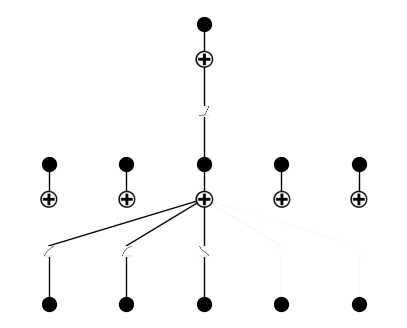

In [43]:
# Visualizamos la red
model.plot()

In [44]:
# Podamos la red
pruned_model = model.prune(node_th=1e-1, edge_th=1e-1)

saving model version 0.2


Una vez hemos realizado la poda, esas entradas ya no se muestran.

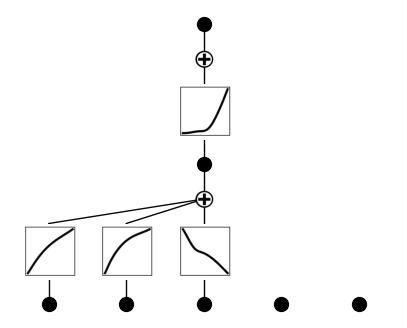

In [45]:
# Mostramos el modelo podado
pruned_model.plot()

In [46]:
# Volvemos a entrenar el modelo tras la poda
pruned_model.fit(dataset, opt="LBFGS", steps=100);

| train_loss: 1.24e-02 | test_loss: 1.65e-02 | reg: 1.19e+01 | : 100%|█| 100/100 [00:19<00:00,  5.02

saving model version 0.3


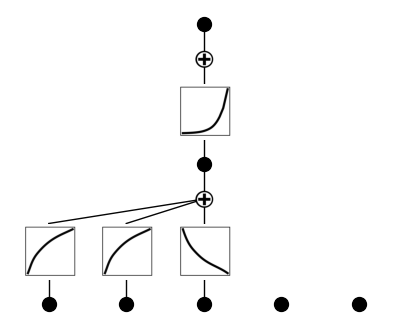

In [47]:
pruned_model.plot()

In [48]:
# Vamos a ver si podemos ajustar funciones simbólicas
pruned_model.suggest_symbolic(0,0,0);
pruned_model.suggest_symbolic(0,1,0);
pruned_model.suggest_symbolic(0,2,0);
pruned_model.suggest_symbolic(1,0,0);

    function  fitting r2    r2 loss  complexity  complexity loss  total loss
0        log    0.999683 -11.577995           2                2   -0.715599
1    1/x^0.5    0.999503 -10.946792           2                2   -0.589358
2  1/sqrt(x)    0.999503 -10.946792           2                2   -0.589358
3        1/x    0.999162 -10.203781           2                2   -0.440756
4      1/x^2    0.998664  -9.536746           2                2   -0.307349
    function  fitting r2    r2 loss  complexity  complexity loss  total loss
0        log    0.999673 -11.533217           2                2   -0.706643
1    1/x^0.5    0.999468 -10.849654           2                2   -0.569931
2  1/sqrt(x)    0.999468 -10.849654           2                2   -0.569931
3        1/x    0.999108 -10.114325           2                2   -0.422865
4      1/x^2    0.998587  -9.456740           2                2   -0.291348
    function  fitting r2    r2 loss  complexity  complexity loss  total loss

Podemos utilizar un razonamiento similar al del otro cuardernillo para elegir $\log$ en la primera capa y $\exp$ en la segunda.

In [49]:
# Fijamos las funciones de activación a las funciones simbólicas siguientes
pruned_model.fix_symbolic(0,0,0, 'log');
pruned_model.fix_symbolic(0,1,0, 'log');
pruned_model.fix_symbolic(0,2,0, 'log');
pruned_model.fix_symbolic(1,0,0, 'exp');

Best value at boundary.
r2 is 0.9996829032897949
saving model version 0.4
Best value at boundary.
r2 is 0.9996725916862488
saving model version 0.5
r2 is 0.9998096227645874
saving model version 0.6
r2 is 0.9998887181282043
saving model version 0.7


Volvemso a entrenar el modelo y vemos el resultado.

In [50]:
# Volvemos a entrenar el modelo
pruned_model.fit(dataset, opt="LBFGS", steps=100);

| train_loss: 9.87e-04 | test_loss: 1.00e-03 | reg: 0.00e+00 | : 100%|█| 100/100 [00:08<00:00, 11.74

saving model version 0.8


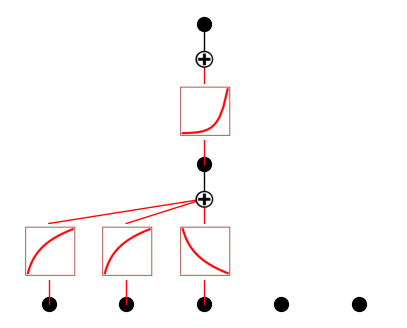

In [51]:
pruned_model.plot()

Como podemos ver, obtenemos una aproximación muy buena donde las dos variables que hemos introducido de forma artificial no aparecen.

In [52]:
formula = pruned_model.symbolic_formula()[0][0]
ex_round(formula, 4)

2.7727*x_1**1.0*(x_2 - 0.0001)**0.9999/(x_3 - 0.0001)**1.9998

## $\sigma = 0.01$

In [53]:
# Iniciamos la KAN
model = KAN(width=[5,5,1], grid=3, k=3, seed=2025, device=device);

dataset = create_dataset_extra_input(error=0.01)

checkpoint directory created: ./model
saving model version 0.0


In [54]:
# Entrenamos la red con regularización
model.fit(dataset, opt="LBFGS", steps=50, lamb=0.03);

| train_loss: 3.50e-01 | test_loss: 3.05e-01 | reg: 6.37e+00 | : 100%|█| 50/50 [00:13<00:00,  3.69it

saving model version 0.1


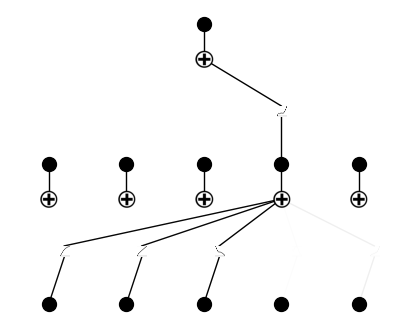

In [55]:
# Visualizamos la red
model.plot()

In [56]:
# Podamos la red
pruned_model = model.prune(node_th=1e-1, edge_th=1e-1)

saving model version 0.2


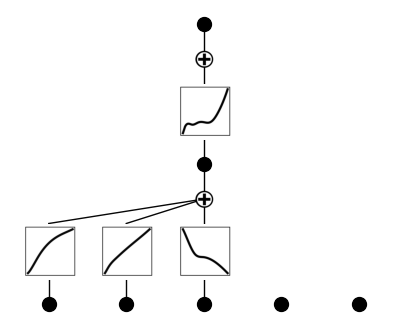

In [57]:
# Mostramos el modelo podado
pruned_model.plot()

In [58]:
# Volvemos a entrenar el modelo tras la poda
pruned_model.fit(dataset, opt="LBFGS", steps=100);

| train_loss: 1.66e-02 | test_loss: 1.74e-02 | reg: 1.03e+01 | : 100%|█| 100/100 [00:20<00:00,  4.82

saving model version 0.3


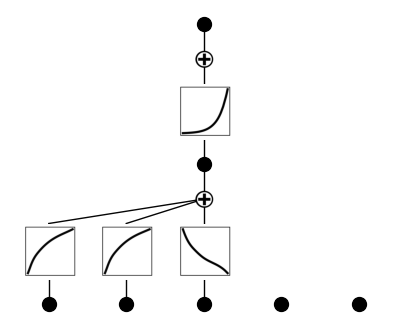

In [59]:
pruned_model.plot()

In [60]:
# Vamos a ver si podemos ajustar funciones simbólicas
pruned_model.suggest_symbolic(0,0,0);
pruned_model.suggest_symbolic(0,1,0);
pruned_model.suggest_symbolic(0,2,0);
pruned_model.suggest_symbolic(1,0,0);

    function  fitting r2    r2 loss  complexity  complexity loss  total loss
0        log    0.999660 -11.478455           2                2   -0.695691
1    1/x^0.5    0.999650 -11.439960           2                2   -0.687992
2  1/sqrt(x)    0.999650 -11.439960           2                2   -0.687992
3        1/x    0.999375 -10.620517           2                2   -0.524103
4      1/x^2    0.998927  -9.850986           2                2   -0.370197
    function  fitting r2    r2 loss  complexity  complexity loss  total loss
0    1/x^0.5    0.999612 -11.296362           2                2   -0.659272
1  1/sqrt(x)    0.999612 -11.296362           2                2   -0.659272
2        log    0.999583 -11.194504           2                2   -0.638901
3        1/x    0.999361 -10.589049           2                2   -0.517810
4      1/x^2    0.998942  -9.870252           2                2   -0.374050
    function  fitting r2    r2 loss  complexity  complexity loss  total loss

In [61]:
# Fijamos las funciones de activación a las funciones simbólicas siguientes
pruned_model.fix_symbolic(0,0,0, 'log');
pruned_model.fix_symbolic(0,1,0, 'log');
pruned_model.fix_symbolic(0,2,0, 'log');
pruned_model.fix_symbolic(1,0,0, 'exp');

Best value at boundary.
r2 is 0.999659538269043
saving model version 0.4
r2 is 0.9995833039283752
saving model version 0.5
r2 is 0.9994139671325684
saving model version 0.6
r2 is 0.9999874234199524
saving model version 0.7


In [62]:
# Volvemos a entrenar el modelo
pruned_model.fit(dataset, opt="LBFGS", steps=100);

| train_loss: 1.01e-02 | test_loss: 9.82e-03 | reg: 0.00e+00 | : 100%|█| 100/100 [00:08<00:00, 12.40

saving model version 0.8


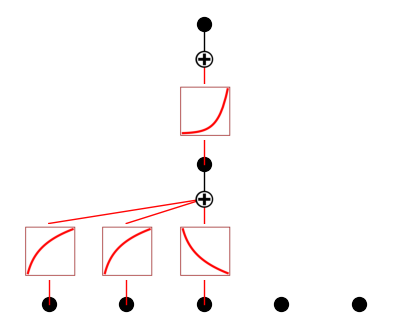

In [63]:
pruned_model.plot()

Vemos como en este caso el error es mucho mayor que antes.

In [64]:
formula = pruned_model.symbolic_formula()[0][0]
ex_round(formula, 4)

2.7866*(x_1 + 0.0008)**1.0014*(x_2 - 0.0002)**1.0005/(x_3 + 0.0037)**2.0053 + 0.0019

## $\sigma = 0.1$

In [65]:
# Iniciamos la KAN
model = KAN(width=[5,5,1], grid=3, k=3, seed=2024, device=device);

dataset = create_dataset_extra_input(error=0.1)

checkpoint directory created: ./model
saving model version 0.0


In [66]:
# Entrenamos la red con regularización
model.fit(dataset, opt="LBFGS", steps=50, lamb=0.03);

| train_loss: 2.94e-01 | test_loss: 2.12e-01 | reg: 4.72e+00 | : 100%|█| 50/50 [00:12<00:00,  3.86it

saving model version 0.1


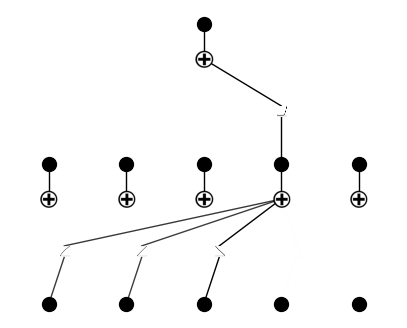

In [67]:
# Visualizamos la red
model.plot()

In [68]:
# Podamos la red
pruned_model = model.prune(node_th=1e-1, edge_th=1e-1)

saving model version 0.2


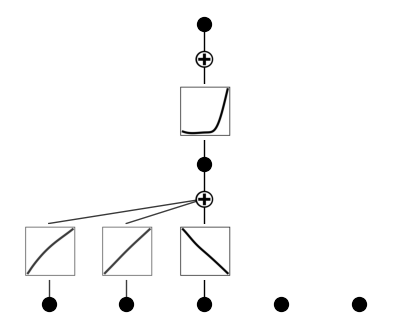

In [69]:
# Mostramos el modelo podado
pruned_model.plot()

In [70]:
# Volvemos a entrenar el modelo
pruned_model.fit(dataset, opt="LBFGS", steps=100);

| train_loss: 7.98e-02 | test_loss: 7.74e-02 | reg: 7.88e+00 | : 100%|█| 100/100 [00:17<00:00,  5.76

saving model version 0.3


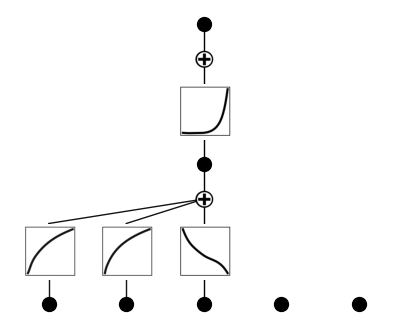

In [71]:
pruned_model.plot()

In [72]:
# Vamos a ver si podemos ajustar funciones simbólicas
pruned_model.suggest_symbolic(0,0,0);
pruned_model.suggest_symbolic(0,1,0);
pruned_model.suggest_symbolic(0,2,0);
pruned_model.suggest_symbolic(1,0,0);

    function  fitting r2    r2 loss  complexity  complexity loss  total loss
0        log    0.999617 -11.311799           2                2   -0.662360
1    1/x^0.5    0.999360 -10.587196           2                2   -0.517439
2  1/sqrt(x)    0.999360 -10.587196           2                2   -0.517439
3        1/x    0.998994  -9.943212           2                2   -0.388642
4      1/x^2    0.998478  -9.350644           2                2   -0.270129
    function  fitting r2    r2 loss  complexity  complexity loss  total loss
0        log    0.999821 -12.367108           2                2   -0.873422
1    1/x^0.5    0.999269 -10.397676           2                2   -0.479535
2  1/sqrt(x)    0.999269 -10.397676           2                2   -0.479535
3        1/x    0.998760  -9.643564           2                2   -0.328713
4      1/x^2    0.998100  -9.032019           2                2   -0.206404
  function  fitting r2   r2 loss  complexity  complexity loss  total loss
0 

In [73]:
# Fijamos las funciones de activación a las funciones simbólicas siguientes
pruned_model.fix_symbolic(0,0,0, 'log');
pruned_model.fix_symbolic(0,1,0, 'log');
pruned_model.fix_symbolic(0,2,0, 'log');
pruned_model.fix_symbolic(1,0,0, 'exp');

r2 is 0.9996166229248047
saving model version 0.4
r2 is 0.9998207092285156
saving model version 0.5
r2 is 0.9950607419013977
saving model version 0.6
r2 is 0.997803270816803
saving model version 0.7


In [74]:
# Volvemos a entrenar el modelo
pruned_model.fit(dataset, opt="LBFGS", steps=100);

| train_loss: 8.42e-02 | test_loss: 8.27e-02 | reg: 0.00e+00 | : 100%|█| 100/100 [00:08<00:00, 11.35

saving model version 0.8


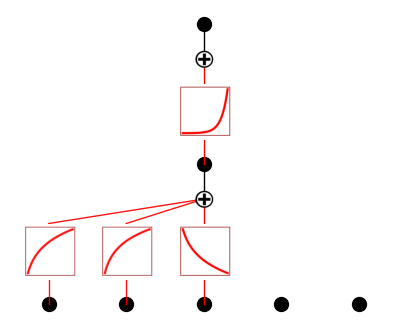

In [75]:
pruned_model.plot()

El error producido es bastante más grande.

In [76]:
formula = pruned_model.symbolic_formula()[0][0]
ex_round(formula, 4)

3.0537*(x_1 + 0.0592)**1.0911*(x_2 - 0.0484)**1.0104/(x_3 + 0.0835)**2.2022 + 0.0917